Análisis de atributos protegidos con fairlearn
==============================================


## ¿Que significa que un modelo sea justo?

A medida que los modelos predictivos de Machine Learning avanzan más y más en nuestro día a día para decidir, informar y también actuar sobre nuestras vidas, muchas preguntas se nos aparecen sobre qué tan “justas” son tales decisiones que los sistemas toman. De particular interés es el evitar que estas decisiones terminen afectando a grupos minoritarios de forma inequitativa discriminando por género, raza, religión, etc. 

Un sistema basado en modelos de aprendizaje automático puede comportarse de manera injusta ante sus usuarios por diversas razones. A veces se debe a sesgos sociales reflejados en los datos de entrenamiento y en las decisiones tomadas durante el desarrollo. En otros casos, los sistemas se comportan injustamente no por sesgos sociales, sino por las características de los datos (por ejemplo, muy pocos datos sobre algún grupo de personas en particular). Puede ser difícil distinguir entre estas razones, especialmente porque no son mutuamente excluyentes y, a menudo, se exacerban entre sí.

Por lo tanto, definimos si un modelo de aprendizaje automático se está comportando injustamente en términos de su impacto en las personas, es decir, en términos de daños, y no en términos de causas específicas, como sesgos sociales, o en términos de intenciones, como prejuicios.

> Para una análisis más profundo sobre este tema puede ver el artículo: [¿Qué significa que un modelo sea justo?](https://santiagof.medium.com/qu%C3%A9-significa-que-un-modelo-sea-justo-793be6741b95)

## ¿Que es fairlearn?

fairlearn es un paquete de Python que puede ayudar a evaluar y mitigar la no imparcialidad en los modelos de aprendizaje automático. Sin embargo, no pierda de vista que la equidad es un desafío fundamentalmente sociotécnico y no se puede resolver solo con herramientas tecnológicas. Dicho esto, fairlearn puede ser útil para ciertas tareas, como evaluar la injusticia a través de varias métricas, o para mitigar la injusticia observada al entrenar un modelo. 

Instalamos la librerias necesarias

In [ ]:
!wget https://raw.githubusercontent.com/santiagxf/E72102/master/docs/develop/modeling/selection/code/fairlearn.txt \
    --quiet --no-clobber
!pip install -r fairlearn.txt --quiet

## Utilizando fairlearn en el problema censo de la UCI

### Sobre el conjunto de datos del censo UCI

El conjunto de datos del censo de la UCI es un conjunto de datos en el que cada registro representa a una persona. Cada registro contiene 14 columnas que describen a una una sola persona, de la base de datos del censo de Estados Unidos de 1994. Esto incluye información como la edad, el estado civil y el nivel educativo. La tarea es determinar si una persona tiene un ingreso alto (definido como ganar más de $50 mil al año). Esta tarea, dado el tipo de datos que utiliza, se usa a menudo en el estudio de equidad, en parte debido a los atributos comprensibles del conjunto de datos, incluidos algunos que contienen tipos sensibles como la edad y el género, y en parte también porque comprende una tarea claramente del mundo real.

Descargamos el conjunto de datos

In [ ]:
!wget https://santiagxf.blob.core.windows.net/public/datasets/uci_census.zip \
    --quiet --no-clobber
!mkdir -p datasets
!unzip -qq uci_census.zip -d datasets

Lo importamos

In [1]:
import pandas as pd

train = pd.read_csv('datasets/uci_census/data/adult-train.csv')

X_train = train.drop(['income'], axis=1)
y_train = train['income'].to_numpy()

### Utilizando métricas para identificar paridades

Podemos utilizar algunas métricas para identificar disparidades que se encuentran directamente en nuestro conjunto de datos:

- `selection_rate`: Calcula la fracción de predicciones que coninciden con el resultado "positivo"

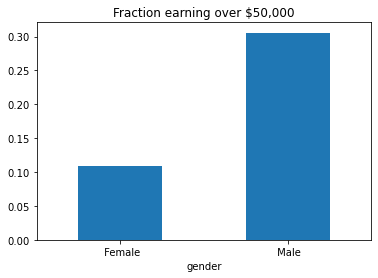

In [2]:
from fairlearn.metrics import MetricFrame, selection_rate

y_true = (y_train == '>50K') * 1
gender = X_train['gender']

selection_rates = MetricFrame(metrics=selection_rate,
                              y_true=y_true,
                              y_pred=y_true,
                              sensitive_features=gender)

fig = selection_rates.by_group.plot.bar(
    legend=False, rot=0,
    title='Fraction earning over $50,000')

### Evaluando la imparcialidad de un modelo

Utilizaremos el modelo entrenado en un ejercicio anterior para evaluar las métricas de imparcialidad. Las predicciones del modelo se cargaron agregaron en el archivo `adult-test-scored.csv`:

In [3]:
scored_dataset = pd.read_csv('datasets/uci_census/data/adult-test-scored.csv')
gender = scored_dataset['gender']

Necesitamos las categorias codificadas de forma numerica para trabajar con las métricas de aquí en adelante:

In [4]:
y_pred = (scored_dataset['score'] == '>50K') * 1
y_true = (scored_dataset['income'] == '>50K') * 1

Calculamos la métrica `accuracy`

In [5]:
from sklearn.metrics import accuracy_score

gm = MetricFrame(metrics=accuracy_score, y_true=y_true, y_pred=y_pred, sensitive_features=gender)

En general, el modelo tiene la siguiente performance según la métrica `accuracy`

In [6]:
print(gm.overall)

0.821012868155155


Sin embargo, si examinamos la métrica para cada grupo, el valor no es el mismo:

In [7]:
print(gm.by_group)

gender
 Female    0.917278
 Male      0.773428
Name: accuracy_score, dtype: object


Además, fairlearn tiene muchas otras métricas integradas, como la tasa de selección, es decir, el porcentaje de la población que tiene "1" como etiqueta:

In [8]:
from fairlearn.metrics import selection_rate

selection_rates = MetricFrame(metrics=selection_rate, 
                              y_true=y_true, 
                              y_pred=y_pred, 
                              sensitive_features=gender)
print(selection_rates.overall)

0.06421792942477196


In [9]:
print(selection_rates.by_group)

gender
 Female    0.027853
 Male      0.082194
Name: selection_rate, dtype: object


Podemos rápidamente graficar estos valores junto con otras métricas interesantes:

array([[<AxesSubplot:title={'center':'accuracy'}, xlabel='gender'>,
        <AxesSubplot:title={'center':'precision'}, xlabel='gender'>,
        <AxesSubplot:title={'center':'recall'}, xlabel='gender'>],
       [<AxesSubplot:title={'center':'false positive rate'}, xlabel='gender'>,
        <AxesSubplot:title={'center':'true positive rate'}, xlabel='gender'>,
        <AxesSubplot:title={'center':'selection rate'}, xlabel='gender'>],
       [<AxesSubplot:title={'center':'count'}, xlabel='gender'>,
        <AxesSubplot:xlabel='gender'>, <AxesSubplot:xlabel='gender'>]],
      dtype=object)

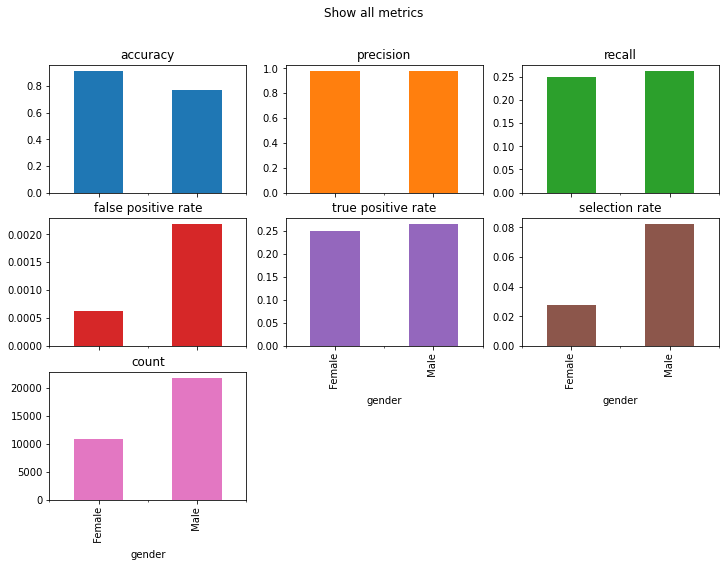

In [10]:
from fairlearn.metrics import *
from sklearn.metrics import accuracy_score, precision_score, recall_score

metrics = {
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'false positive rate': false_positive_rate,
    'true positive rate': true_positive_rate,
    'selection rate': selection_rate,
    'count': count}

metric_frame = MetricFrame(metrics=metrics,
                           y_true=y_true,
                           y_pred=y_pred,
                           sensitive_features=gender)

metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)